In [1]:
import os
os.chdir("../../")

In [2]:
import glob
import numpy as np
from cids.util import metrics
import torch
from torch import nn
from cids.util import misc_funcs as misc#
from cids.models.nn import MLP, Autoencoder 
from sklearn.manifold import TSNE
from cids.data import OpTCDataset
import matplotlib.gridspec as gridspec

from matplotlib.lines import Line2D

import matplotlib.pyplot as plt

In [3]:
model_path = os.path.join(misc.root(), "models/03_semisupervision/finetuned/MLPAE-201/SSL-FULL-ITER-201-2/reciprocal--gamma1.25--lr1.085e-06/seed10/ 20.pt")
model_path_base = os.path.join(misc.root(), "models/03_semisupervision/unsupervised/OpTC/MLPAE-201/BASE-201-1/BASE-201-1-9/ckpt.pt")
score_path = os.path.join(misc.root(), "results/03_semisupervision/finetuned/MLPAE-201/SSL-FULL-ITER-201-2/reciprocal--gamma1.25--lr1.085e-06/seed10")
score_path_base = os.path.join(misc.root(),"results/03_semisupervision/unsupervised/OpTC/MLPAE-201/BASE-201-1/BASE-201-1-9")
model_config = {
    "input_dim": 1690,
    "output_dim": 5,
    "hidden_dims":  [128]
}

data_config = {
    "ds_name": "cids-v5_201_eval-ff_train--201",
    # "ds_name": "cids-v5_201_eval-ff_eval--benign_only--503-559-609",
    "parts": 4,
    "window_size": 10,
    "shuffle": False,
    "stage": 5,
    "only_benign": False,
    "eval_mode": True
    }

In [4]:
ckpt = torch.load(model_path, map_location="cpu", weights_only=False)
encoder = MLP(**model_config)
model_config["input_dim"], model_config["output_dim"] = model_config["output_dim"], model_config["input_dim"]
decoder = MLP(**model_config)
decoder = nn.Sequential(decoder, nn.Sigmoid())

model = Autoencoder(encoder=encoder, decoder=decoder)
model.load_state_dict(ckpt["model_state_dict"])
model.eval()

model_config["input_dim"], model_config["output_dim"] = model_config["output_dim"], model_config["input_dim"]
ckpt = torch.load(model_path_base, map_location="cpu", weights_only=False)
encoder = MLP(**model_config)
model_config["input_dim"], model_config["output_dim"] = model_config["output_dim"], model_config["input_dim"]
decoder = MLP(**model_config)
decoder = nn.Sequential(decoder, nn.Sigmoid())

model_base = Autoencoder(encoder=encoder, decoder=decoder)
model_base.load_state_dict(ckpt["model_state_dict"])
model_base.eval()

Autoencoder(
  (encoder): MLP(
    (input_layer): Linear(in_features=1690, out_features=128, bias=True)
    (hidden_layers): ModuleList()
    (output_layer): Linear(in_features=128, out_features=5, bias=True)
    (dropout): Identity()
  )
  (decoder): Sequential(
    (0): MLP(
      (input_layer): Linear(in_features=5, out_features=128, bias=True)
      (hidden_layers): ModuleList()
      (output_layer): Linear(in_features=128, out_features=1690, bias=True)
      (dropout): Identity()
    )
    (1): Sigmoid()
  )
)

In [5]:
dataset = OpTCDataset(**data_config)
loader = torch.utils.data.DataLoader(dataset, batch_size=32, shuffle=False)

In [6]:
embeddings = []
embeddings_base = []
labels = []

for inp, lbl in loader:
    inp = torch.flatten(inp, start_dim=1)
    out = model.encode(inp)
    out_base = model_base.encode(inp)
    
    embeddings.extend(out.cpu().detach().numpy())
    embeddings_base.extend(out_base.cpu().detach().numpy())
    labels.extend(lbl.cpu().detach().numpy())

embeddings = np.asarray(embeddings)
embeddings_base = np.asarray(embeddings_base)
print(embeddings.shape)




(1639601, 5)


In [7]:
def get_threshold_iqr(run):
    scores = np.load(os.path.join(run, "train_scores.npy"))
    labels = np.load(os.path.join(run, "train_labels.npy"))

    benign_scores = scores[labels == 0]
    q1 = np.quantile(benign_scores, 0.25)
    q3 = np.quantile(benign_scores, 0.75)
    iqr = q3 - q1
    threshold = (q3 + 1.5 * iqr)
    return threshold, (scores, labels)

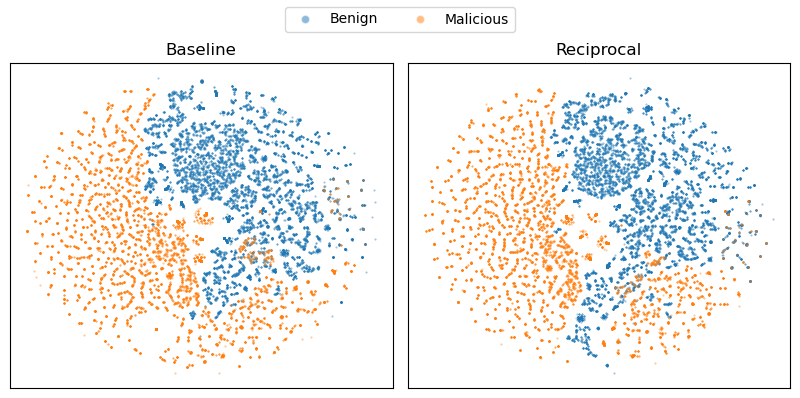

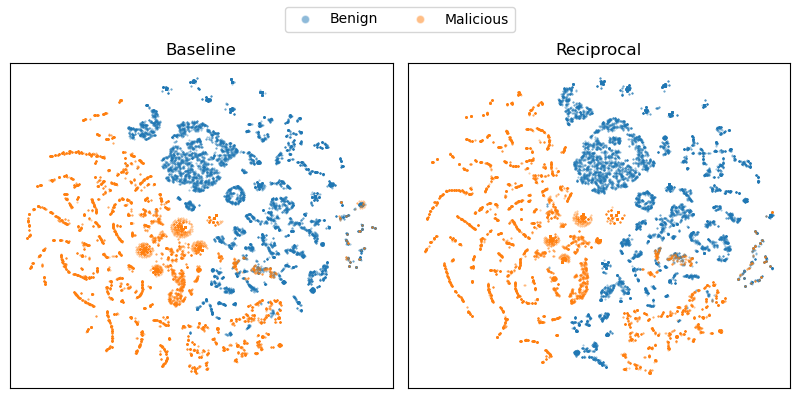

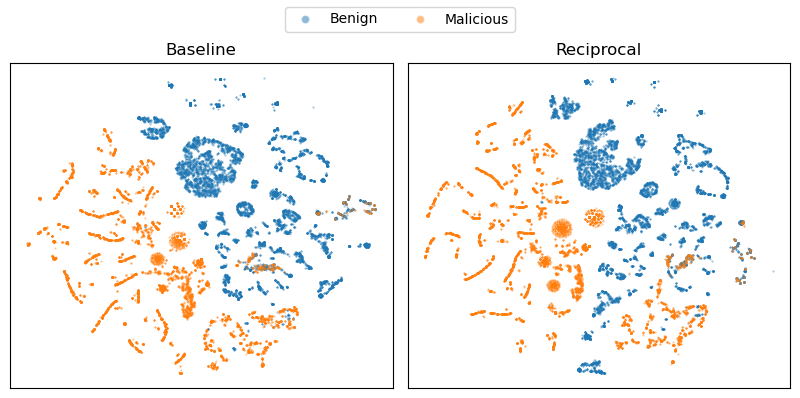

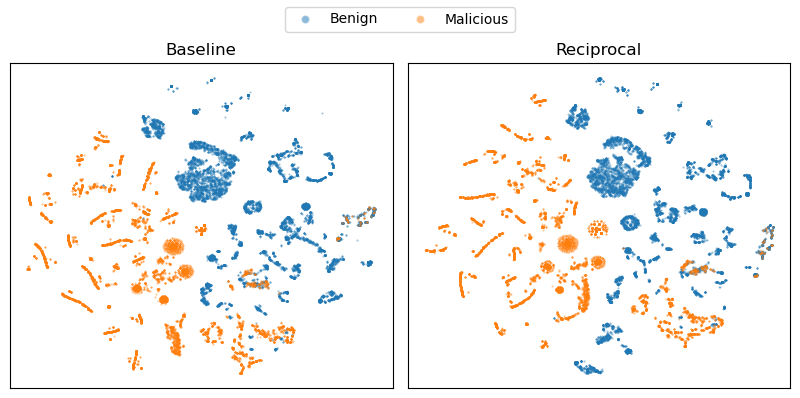

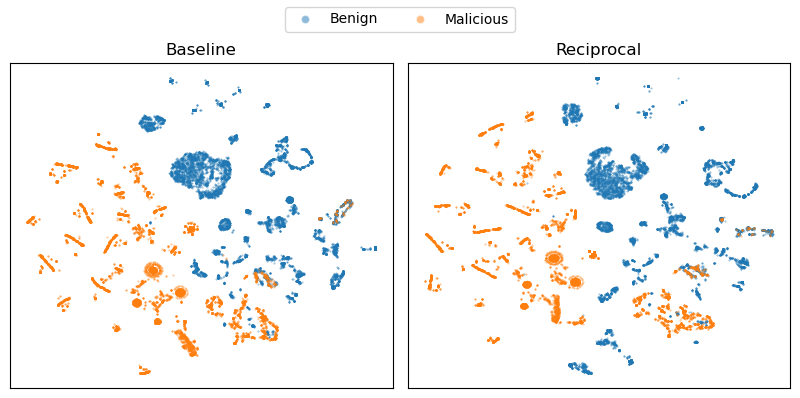

In [ ]:
scores = np.load(os.path.join(score_path, "test_scores.npy"))
scores_base = np.load(os.path.join(score_path_base, "test_scores.npy"))
t, _ = get_threshold_iqr(score_path)
t_base, _ = get_threshold_iqr(score_path_base)
for p in [10, 30, 50, 70, 100]:
    samples_per_class = 10000
    labels = np.asarray(labels)
    fig, axs = plt.subplots(1, 2, figsize=(8.1, 4))
    scatter_size = 0.2  # Small scatter points

    for ax, emb, t in zip(axs, [embeddings_base, embeddings], ["Baseline", "Reciprocal"]):
        benign_samples = emb[labels == 0]
        benign_samples = benign_samples[np.random.randint(len(benign_samples), size=samples_per_class)]

        mal_samples = emb[labels == 1]
        mal_samples = mal_samples[np.random.randint(len(mal_samples), size=samples_per_class)]

        tsne = TSNE(n_components=2, learning_rate="auto", perplexity=p)
        y = tsne.fit_transform(np.concatenate([benign_samples, mal_samples]))

        ax.scatter(y[:samples_per_class, 0], y[:samples_per_class, 1],
                   c='#1f77b4', label='Benign', alpha=0.5, s=scatter_size)
        ax.scatter(y[samples_per_class:, 0], y[samples_per_class:, 1],
                   c='#ff7f0e', label='Malicious', alpha=0.5, s=scatter_size)

        ax.set_title(t)
        ax.set_xticks([])
        ax.set_yticks([])

    # Custom legend handles with larger marker size
    legend_handles = [
        Line2D([0], [0], marker='o', color='w', label='Benign',
               markerfacecolor='#1f77b4', markersize=6, alpha=0.5),
        Line2D([0], [0], marker='o', color='w', label='Malicious',
               markerfacecolor='#ff7f0e', markersize=6, alpha=0.5),
    ]

    fig.legend(handles=legend_handles, loc='upper center', ncol=2, frameon=True)
    fig.tight_layout()
    fig.subplots_adjust(top=0.85)

    plt.show()
    plt.close(fig)

/tmp/ipykernel_1138275/3925567797.py:112: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


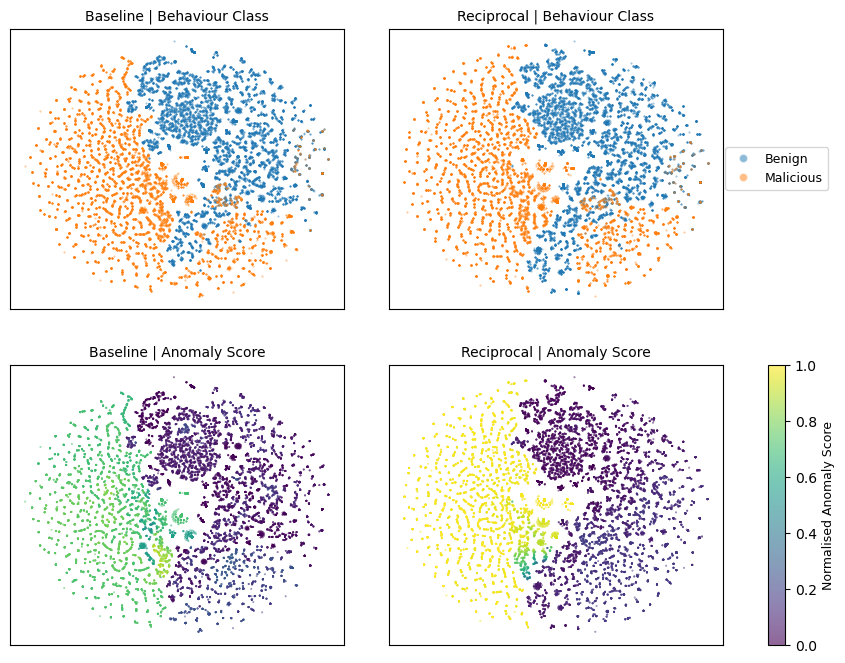

/tmp/ipykernel_1138275/3925567797.py:112: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


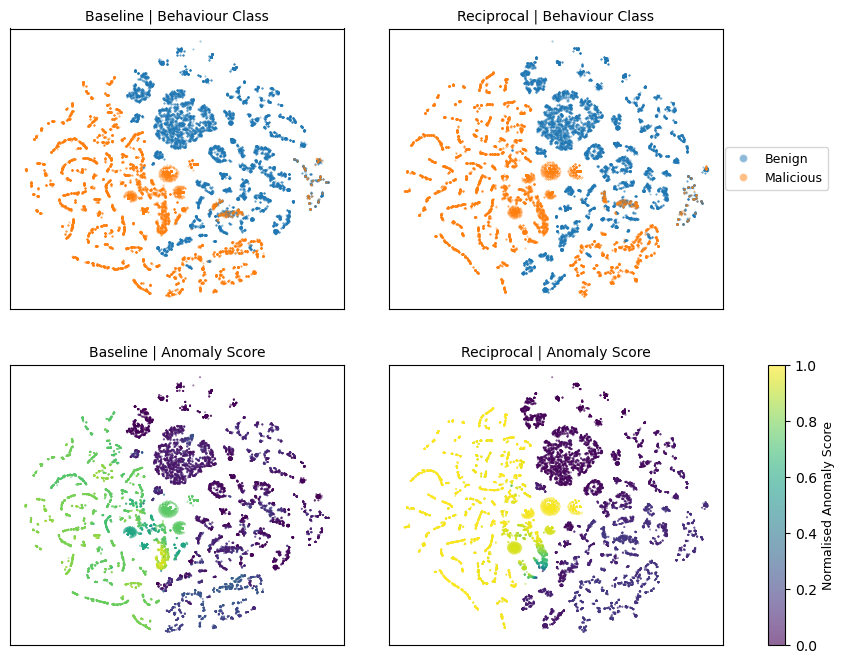

/tmp/ipykernel_1138275/3925567797.py:112: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


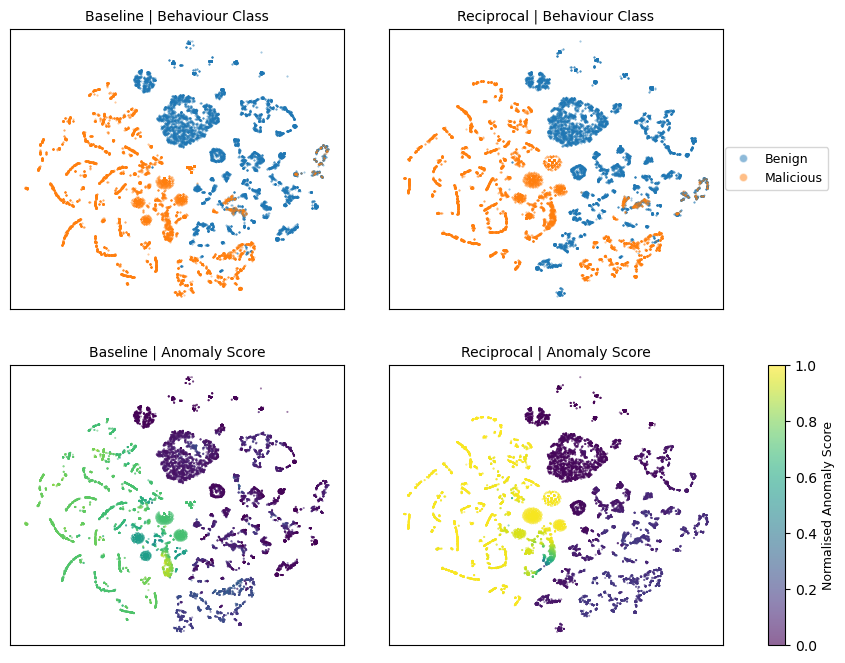

/tmp/ipykernel_1138275/3925567797.py:112: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


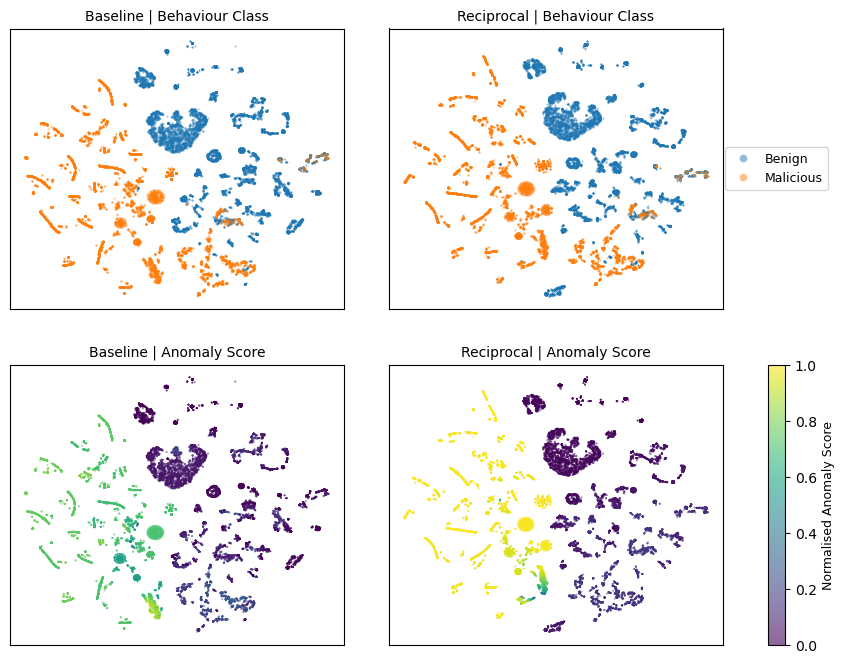

/tmp/ipykernel_1138275/3925567797.py:112: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


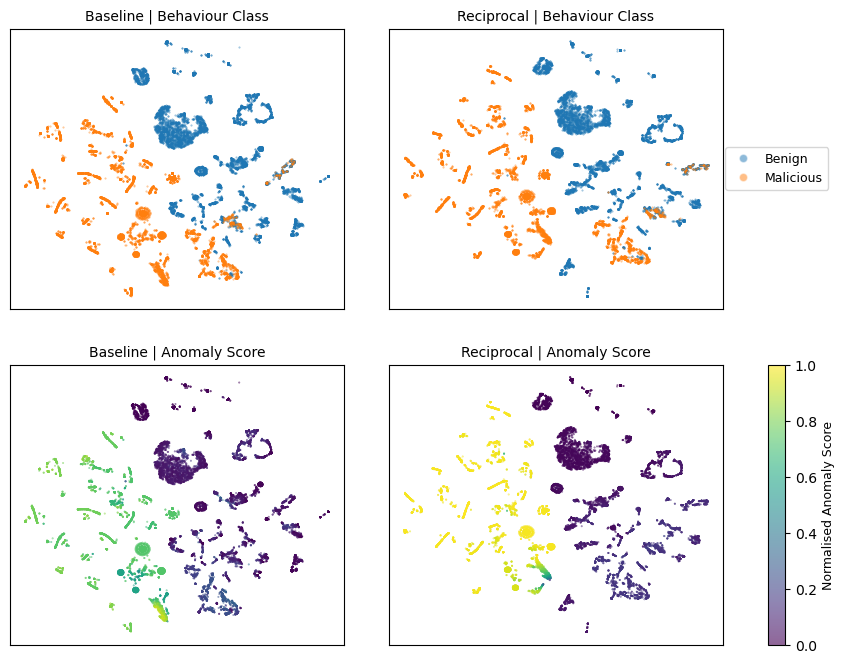

In [ ]:
from sklearn.manifold import TSNE
from matplotlib.lines import Line2D
import matplotlib.gridspec as gridspec
plt.rcParamsDefault.update({'font.size': 12})
# Load data
scores = np.load(os.path.join(score_path, "test_scores.npy"))
scores_base = np.load(os.path.join(score_path_base, "test_scores.npy"))
t, _ = get_threshold_iqr(score_path)
t_base, _ = get_threshold_iqr(score_path_base)

perplexities = [10, 30, 50, 70, 100]
samples_per_class = 10000
labels = np.asarray(labels)
scatter_size = 0.2
norm_intra_model = True

for p in perplexities:
    # === Setup figure and layout ===
    fig = plt.figure(figsize=(10, 8))
    gs = gridspec.GridSpec(2, 3, width_ratios=[1, 1, 0.05], wspace=0.2, hspace=0.2)

    axs = np.empty((2, 2), dtype=object)
    axs[0, 0] = fig.add_subplot(gs[0, 0])
    axs[0, 1] = fig.add_subplot(gs[0, 1])
    axs[1, 0] = fig.add_subplot(gs[1, 0])
    axs[1, 1] = fig.add_subplot(gs[1, 1])
    cax = fig.add_subplot(gs[1, 2])  # Colorbar axis
    legend_ax = fig.add_subplot(gs[0, 2])  # Legend axis
    legend_ax.axis('off')  # Hide legend axis frame

    # === Sample once per perplexity ===
    benign_idx = np.where(labels == 0)[0]
    malicious_idx = np.where(labels == 1)[0]
    benign_sample_idx = np.random.choice(benign_idx, size=samples_per_class, replace=False)
    mal_sample_idx = np.random.choice(malicious_idx, size=samples_per_class, replace=False)
    sample_indices = np.concatenate([benign_sample_idx, mal_sample_idx])

    # Prepare data
    emb_sets = {
        "Baseline": embeddings_base[sample_indices],
        "Reciprocal": embeddings[sample_indices],
    }
    # === Normalize scores across both models ===
    if not norm_intra_model:
        all_scores = np.concatenate([scores_base[sample_indices], scores[sample_indices]])
        score_min = np.min(all_scores)
        score_max = np.max(all_scores)

        # Apply min-max normalization
        score_sets = {
            "Baseline": (scores_base[sample_indices] - score_min) / (score_max - score_min),
            "Reciprocal": (scores[sample_indices] - score_min) / (score_max - score_min),
        }
    else:
        # === Normalize scores per model ===
        def minmax_normalize(arr):
            return (arr - np.min(arr)) / (np.max(arr) - np.min(arr) + 1e-8)  # small epsilon to avoid divide-by-zero

        score_sets = {
            "Baseline": minmax_normalize(scores_base[sample_indices]),
            "Reciprocal": minmax_normalize(scores[sample_indices]),
        }

    label_subset = labels[sample_indices]
    # t-SNE on same subset
    tsne_sets = {}
    for model_label, emb_subset in emb_sets.items():
        tsne = TSNE(n_components=2, learning_rate="auto", perplexity=p)
        tsne_sets[model_label] = tsne.fit_transform(emb_subset)

    # === Plotting ===
    colorbar_plot = None  # Will hold last scatter for colorbar
    for col, model_label in enumerate(["Baseline", "Reciprocal"]):
        y = tsne_sets[model_label]
        scores_subset = score_sets[model_label]

        # Row 0: class-based
        ax_class = axs[0, col]
        ax_class.scatter(y[label_subset == 0, 0], y[label_subset == 0, 1],
                         c='#1f77b4', label='Benign', alpha=0.5, s=scatter_size)
        ax_class.scatter(y[label_subset == 1, 0], y[label_subset == 1, 1],
                         c='#ff7f0e', label='Malicious', alpha=0.5, s=scatter_size)
        ax_class.set_title(f"{model_label} | Behaviour Class", fontsize=10)
        ax_class.set_xticks([])
        ax_class.set_yticks([])

        # Row 1: score-based
        ax_score = axs[1, col]
        scatter = ax_score.scatter(y[:, 0], y[:, 1], c=scores_subset,
                                   cmap='viridis', s=scatter_size, alpha=0.6)
        ax_score.set_title(f"{model_label} | Anomaly Score", fontsize=10)
        ax_score.set_xticks([])
        ax_score.set_yticks([])

        # Save scatter for colorbar
        if col == 1:
            colorbar_plot = scatter

    # === Shared legend ===
    legend_handles = [
        Line2D([0], [0], marker='o', color='w', label='Benign',
               markerfacecolor='#1f77b4', markersize=6, alpha=0.5),
        Line2D([0], [0], marker='o', color='w', label='Malicious',
               markerfacecolor='#ff7f0e', markersize=6, alpha=0.5),
    ]
    legend_ax.legend(handles=legend_handles, loc='center', fontsize=9, frameon=True)

    # === Shared colorbar ===
    cbar = fig.colorbar(colorbar_plot, cax=cax)
    cbar.set_label("Normalised Anomaly Score", fontsize=9)

    # fig.suptitle(f"t-SNE Visualization (Perplexity = {p})", fontsize=14)
    #plt.tight_layout(rect=[0, 0, 0.95, 0.95])  # leave room for suptitle
    plt.tight_layout()
    fig.savefig(os.path.join(misc.root(), f"plots/embeddings_reciprocal_seed10_perplexity{p}.pdf"))
    plt.show()
    plt.close(fig)


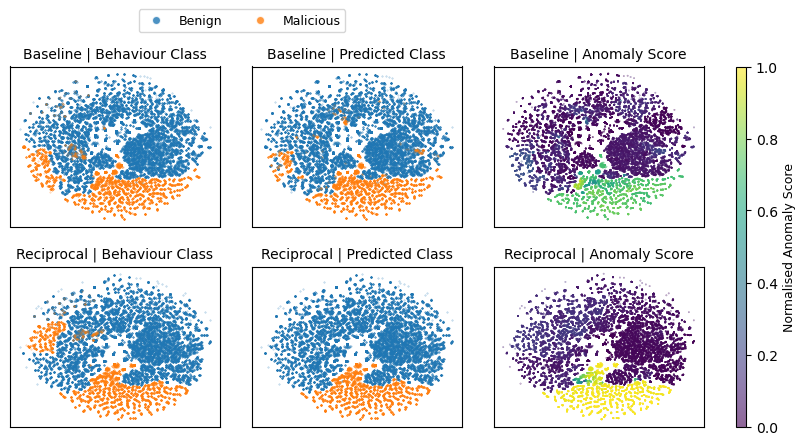

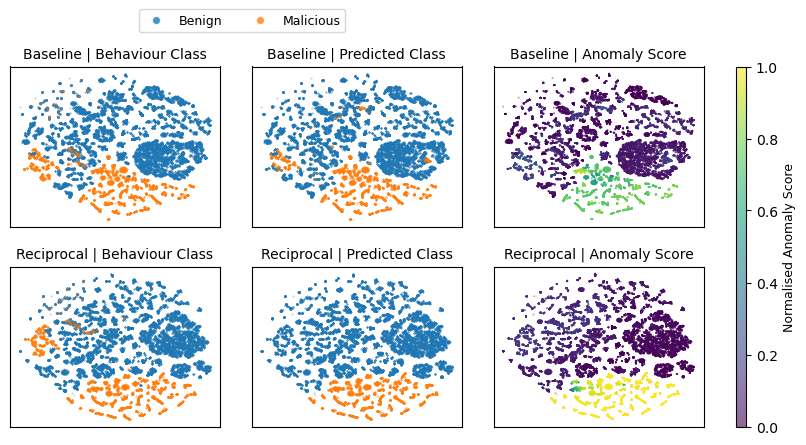

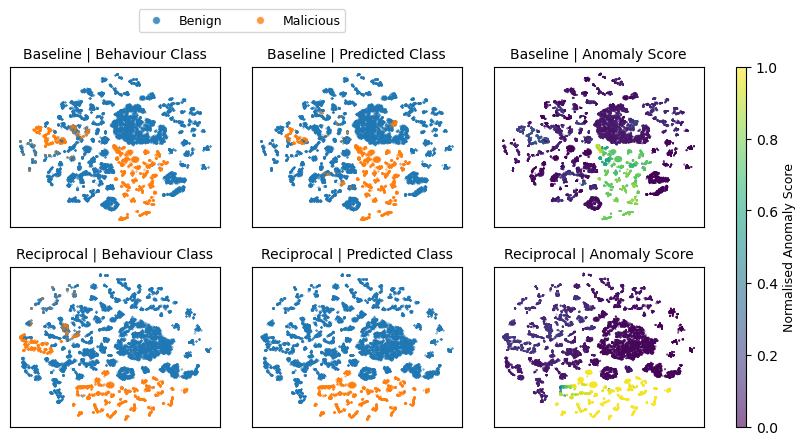

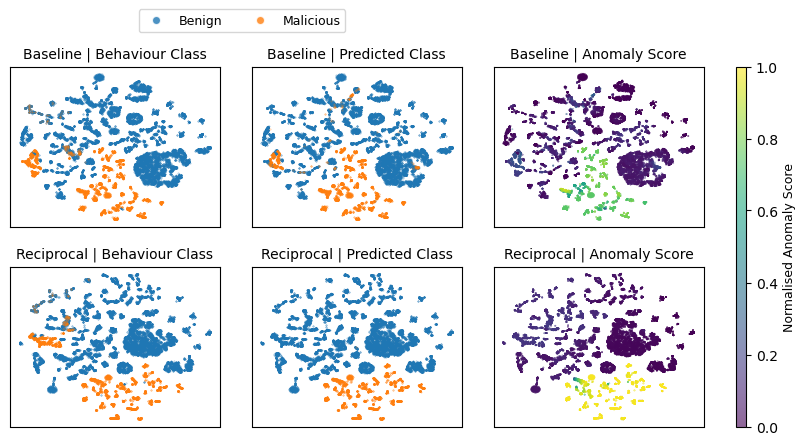

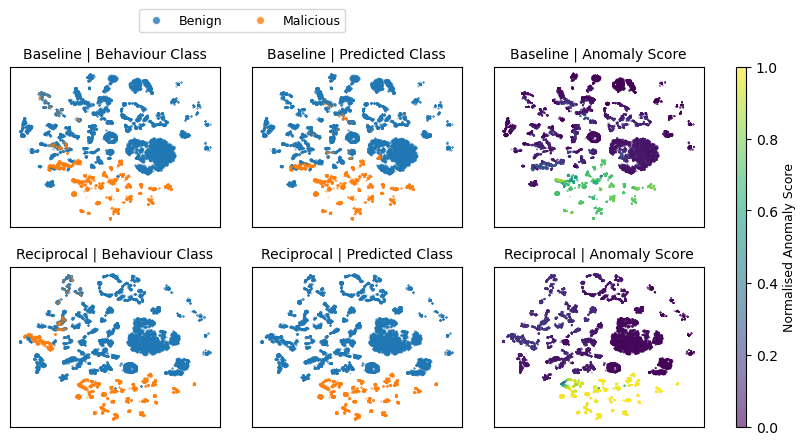

In [10]:
plt.rcParamsDefault.update({'font.size': 12})
# Load data
scores = np.load(os.path.join(score_path, "test_scores.npy"))
scores_base = np.load(os.path.join(score_path_base, "test_scores.npy"))
t, _ = get_threshold_iqr(score_path)
t_base, _ = get_threshold_iqr(score_path_base)

perplexities = [10, 30, 50, 70, 100]
samples_per_class = 15000
labels = np.asarray(labels)
scatter_size = 0.1
norm_intra_model = True

# Set the desired class distribution for sampling (e.g., 0.95 benign, 0.05 malicious)
desired_class_dist = {0: 0.8, 1: 0.2}  # 95% benign, 5% malicious

plot_scores = True  # <--- Set this to False if you do not want to plot the anomaly scores

for p in perplexities:
    # === Setup figure and layout ===
    fig = plt.figure(figsize=(8, 4))  # Wider for transposed layout
    gs = gridspec.GridSpec(2, 4, height_ratios=[1, 1], width_ratios=[1, 1, 1, 0.05], wspace=0.2, hspace=0.25)

    axs = np.empty((2, 3), dtype=object)
    axs[0, 0] = fig.add_subplot(gs[0, 0])
    axs[0, 1] = fig.add_subplot(gs[0, 1])
    axs[0, 2] = fig.add_subplot(gs[0, 2])
    axs[1, 0] = fig.add_subplot(gs[1, 0])
    axs[1, 1] = fig.add_subplot(gs[1, 1])
    axs[1, 2] = fig.add_subplot(gs[1, 2])
    cax = fig.add_subplot(gs[:, 3])  # Colorbar axis (spans both rows)
    legend_ax = fig.add_subplot(gs[:, 2])  # Legend axis (reuse last col, top row)
    legend_ax.axis('off')  # Hide legend axis frame

    # === Sample once per perplexity, using desired_class_dist ===
    total_samples = samples_per_class * 2
    sample_indices = []
    for cls, prop in desired_class_dist.items():
        cls_idx = np.where(labels == cls)[0]
        n_cls = int(total_samples * prop)
        n_cls = min(n_cls, len(cls_idx))
        cls_sample_idx = np.random.choice(cls_idx, size=n_cls, replace=False)
        sample_indices.append(cls_sample_idx)
    sample_indices = np.concatenate(sample_indices)

    # Prepare data
    emb_sets = {
        "Baseline": embeddings_base[sample_indices],
        "Reciprocal": embeddings[sample_indices],
    }
    if not norm_intra_model:
        all_scores = np.concatenate([scores_base[sample_indices], scores[sample_indices]])
        score_min = np.min(all_scores)
        score_max = np.max(all_scores)
        score_sets = {
            "Baseline": (scores_base[sample_indices] - score_min) / (score_max - score_min),
            "Reciprocal": (scores[sample_indices] - score_min) / (score_max - score_min),
        }
    else:
        def minmax_normalize(arr):
            return (arr - np.min(arr)) / (np.max(arr) - np.min(arr) + 1e-8)
        score_sets = {
            "Baseline": minmax_normalize(scores_base[sample_indices]),
            "Reciprocal": minmax_normalize(scores[sample_indices]),
        }

    label_subset = labels[sample_indices]
    pred_labels = {
        "Baseline": (scores_base[sample_indices] > t_base).astype(int),
        "Reciprocal": (scores[sample_indices] > t).astype(int),
    }

    tsne_sets = {}
    for model_label, emb_subset in emb_sets.items():
        tsne = TSNE(n_components=2, learning_rate="auto", perplexity=p)
        tsne_sets[model_label] = tsne.fit_transform(emb_subset)

    # === Plotting ===
    colorbar_plot = None
    row_titles = ["Behaviour Class", "Predicted Class", "Anomaly Score"]
    for row, plot_type in enumerate(["class", "pred", "score"]):
        for col, model_label in enumerate(["Baseline", "Reciprocal"]):
            ax = axs[col, row]
            y = tsne_sets[model_label]
            scores_subset = score_sets[model_label]
            if plot_type == "class":
                ax.scatter(y[label_subset == 0, 0], y[label_subset == 0, 1],
                           c='#1f77b4', label='Benign', alpha=0.5, s=scatter_size)
                ax.scatter(y[label_subset == 1, 0], y[label_subset == 1, 1],
                           c='#ff7f0e', label='Malicious', alpha=0.5, s=scatter_size)
                ax.set_title(f"{model_label} | {row_titles[row]}", fontsize=10)
            elif plot_type == "pred":
                ax.scatter(y[pred_labels[model_label] == 0, 0], y[pred_labels[model_label] == 0, 1],
                           c='#1f77b4', label='Pred. Benign', alpha=0.5, s=scatter_size)
                ax.scatter(y[pred_labels[model_label] == 1, 0], y[pred_labels[model_label] == 1, 1],
                           c='#ff7f0e', label='Pred. Malicious', alpha=0.5, s=scatter_size)
                ax.set_title(f"{model_label} | {row_titles[row]}", fontsize=10)
            elif plot_type == "score":
                if plot_scores:
                    scatter = ax.scatter(y[:, 0], y[:, 1], c=scores_subset,
                                         cmap='viridis', s=scatter_size, alpha=0.6)
                    ax.set_title(f"{model_label} | {row_titles[row]}", fontsize=10)
                    if col == 1:
                        colorbar_plot = scatter
                else:
                    ax.axis('off')
            ax.set_xticks([])
            ax.set_yticks([])

    # === Shared legend ===
    legend_handles = [
        Line2D([0], [0], marker='o', color='w', label='Benign',
               markerfacecolor='#1f77b4', markersize=6, alpha=0.8),
        Line2D([0], [0], marker='o', color='w', label='Malicious',
               markerfacecolor='#ff7f0e', markersize=6, alpha=0.8),
    ]
    # Place legend above the plots, centered between both columns
    fig.legend(
        handles=legend_handles,
        labels=["Benign", "Malicious"],
        loc='lower center',
        bbox_to_anchor=(0.3, 1.02),
        ncol=2,
        frameon=True,
        fontsize=9
    )

    # === Shared colorbar ===
    if plot_scores and colorbar_plot is not None:
        cbar = fig.colorbar(colorbar_plot, cax=cax)
        cbar.set_label("Normalised Anomaly Score", fontsize=9)
    else:
        cax.axis('off')

    plt.subplots_adjust(left=0.01, right=0.93, top=0.95, bottom=0.05, wspace=0.1, hspace=0.2)
    fig.savefig(os.path.join(misc.root(), f"plots/embeddings_reciprocal_seed10_perplexity{p}_transposed.png"), dpi=500, bbox_inches='tight')
    plt.show()
    plt.close(fig)